# **9.3 About Neural ODE : Using Torchdiffeq with Deepchem**

Neural ODEs

기존 딥러닝 : 입력 x가 층을 단계별(Discrete)로 통과하며 변함

Neural ODE : 층과 층 사이를 무한히 쪼개 연속적인 흐름으로 만듬

역전파 시 중간 층의 값을 다 저장할 필요가 없음 -> 메모리 사용량이 매우 적음, 데이터의 흐름에 따라 계산 정밀도 조절

In [1]:
!pip install torchdiffeq
!pip install --pre deepchem

In [11]:
import torch
import torch.nn as nn

from torchdiffeq import odeint
import math
import numpy as np

import deepchem as dc
import matplotlib.pyplot as plt

In [12]:
def f(t,z):
  return t

z0 = torch.Tensor([0])
t = torch.linspace(0,2,100)
out = odeint(f, z0, t);

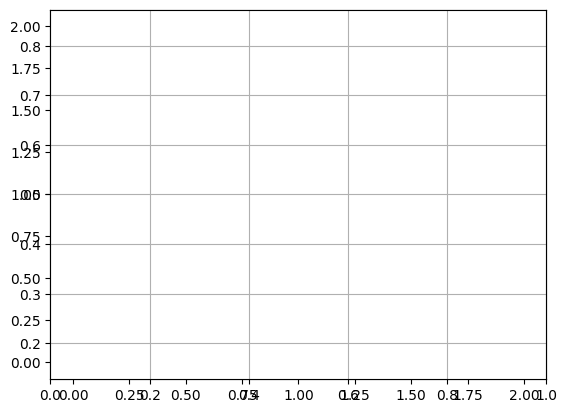

In [13]:
plt.plot(t, out, 'go--')
plt.axes().set_aspect('equal','datalim')
plt.grid()
plt.show()

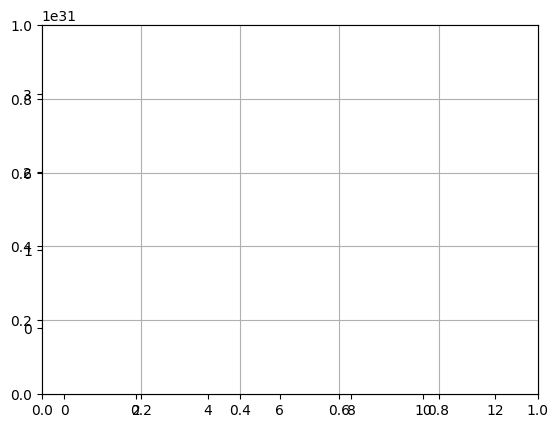

In [14]:
class SystemOfEquations:

  def __init__(self, km, p, g, r):
    self.mat = torch.Tensor([[0,1,0],[-km, p, 0],[0,g,-r]])

  def solve(self, t, x0, dx0, ddx0):
    y0 = torch.cat([x0, dx0, ddx0])
    out = odeint(self.func, y0, t)
    return out

  def func(self, t, y):
    out = y@self.mat
    return out


x0 = torch.Tensor([1])
dx0 = torch.Tensor([0])
ddx0 = torch.Tensor([1])

t = torch.linspace(0, 4*np.pi, 1000)
solver = SystemOfEquations(1,6,3,2)
out = solver.solve(t, x0, dx0, ddx0)

plt.plot(t, out, 'r')
plt.axes()
plt.grid()
plt.show()

In [15]:
from torchdiffeq import odeint_adjoint as odeadj

class f(nn.Module):
  def __init__(self, dim):
    super(f, self).__init__()
    self.model = nn.Sequential(
        nn.Linear(dim,124),
        nn.ReLU(),
        nn.Linear(124,124),
        nn.ReLU(),
        nn.Linear(124,dim),
        nn.Tanh()
    )

  def forward(self, t, x):
    return self.model(x)

In [16]:
class ODEBlock(nn.Module):

  # This is ODEBlock. Think of it as a wrapper over ODE Solver , so as to easily connect it with our neurons !

  def __init__(self, f):
    super(ODEBlock, self).__init__()
    self.f = f
    self.integration_time = torch.Tensor([0,1]).float()

  def forward(self, x):
    self.integration_time = self.integration_time.type_as(x)
    out = odeadj(
        self.f,
        x,
        self.integration_time
    )

    return out[1]


class ODENet(nn.Module):

  #This is our main neural network that uses ODEBlock within a sequential module

  def __init__(self, in_dim, mid_dim, out_dim):
    super(ODENet, self).__init__()
    fx = f(dim=mid_dim)
    self.fc1 = nn.Linear(in_dim, mid_dim)
    self.relu1 = nn.ReLU(inplace=True)
    self.norm1 = nn.BatchNorm1d(mid_dim)
    self.ode_block = ODEBlock(fx)
    self.dropout = nn.Dropout(0.4)
    self.norm2 = nn.BatchNorm1d(mid_dim)
    self.fc2 = nn.Linear(mid_dim, out_dim)

  def forward(self, x):
    batch_size = x.shape[0]
    x = x.view(batch_size, -1)

    out = self.fc1(x)
    out = self.relu1(out)
    out = self.norm1(out)
    out = self.ode_block(out)
    out = self.norm2(out)
    out = self.dropout(out)
    out = self.fc2(out)

    return out

In [ ]:
tasks, dataset, transformers = dc.molnet.load_delaney(featurizer='ECFP', splitter='random')
train_set, valid_set, test_set = dataset
metric = dc.metrics.Metric(dc.metrics.pearson_r2_score)

In [ ]:
# Like mentioned before one can use GPUs with PyTorch and torchdiffeq
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


model = ODENet(in_dim=1024, mid_dim=1000, out_dim=1).to(device)
model = dc.models.TorchModel(model, dc.models.losses.L2Loss())

model.fit(train_set, nb_epoch=50)

print('Training set score : ', model.evaluate(train_set,[metric]))
print('Test set score : ', model.evaluate(test_set,[metric]))

class f

Linear(124) -> ReLU -> Linear(124) -> ReLU -> Linear(dim) -> Tanh

데이터가 t=0 -> t=1로 가는동안 어떤 경로로 변하는 것이 가장 효율적인가

ODEBlock

입력 -> 신령망 f가 변화율 계산, Adjoint Solver가 적분 -> Adjoint Method 역방향 학습 -> 출력


입력값 x를 미분 방정식의 초기값으로 취급, 역전파를 할 때 중간 계산값을 저장하지 않고 시간을 돌려가며 계산(Invertibility)

💡 insight

층(Layer) 간의 변화를 상미분 방정식(ODE)으로 정의하고 블랙박스 솔버를 통해 적분함으로써, 데이터의 특징이 시간에 따라 매끄럽게 진화(Evolution)하는 모델

가역적 연산을 활용해 역전파 시 중간 활성화 값을 저장하지 않는 알고리즘 -> 메모리 제약을 덜 받고 심층 신경망 학습 가능